<a href="https://colab.research.google.com/github/gummy-brain/EDA-of-US-Police-Shootings-Dataset/blob/main/EDA_of_US_Police_Shootings_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project was prepared while studying at Turing College. The objectives were to:

- identify opportunities for data analysis;
- perform EDA;
- work with data from Kaggle;
- visualize data with Matplotlib & Seaborn;
- read data, perform queries, and filter data using Pandas.

The [Fatal Police Shootings in the U.S. '15 - '17](https://www.kaggle.com/washingtonpost/police-shootings) dataset from Kaggle was the cornerstone of this analysis. Additionally, the population data from [2016 US Census](https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?dataView=1&currentTimeframe=3&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D) was used to get more profound insights.


# Exploratory Data Analysis of Fatal Police Shootings in the United States Dataset

## 1 Data Pre-processing

In [ ]:
!python -m pip install -U pip
!python -m pip install -U matplotlib

In [ ]:
!pip install gower

In [ ]:
!pip install kmodes

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime as dt
import textwrap
import missingno as msno
import plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import gower
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from kmodes.kprototypes import KPrototypes

In [ ]:
shootings_data = pd.read_csv("/content/database-us-shootings.csv", 
                             index_col="id")

shootings_data.shape


(2142, 13)

The police shootings dataset has 13 features/variables and 2142 observations.

In [ ]:
shootings_data.head()

,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
id,,,,,,,,,,,,,
3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


To make the analysis more readable, a column with full US state names will be added to `shootings_data`.

In [ ]:
us_state_abbrev = {
    'Alabama': 'AL', 
    'Alaska': 'AK', 
    'Arizona': 'AZ', 
    'Arkansas': 'AR', 
    'California': 'CA', 
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia' : 'DC', 
    'Florida': 'FL', 
    'Georgia': 'GA', 
    'Hawaii': 'HI', 
    'Idaho': 'ID',
    'Illinois': 'IL', 
    'Indiana': 'IN', 
    'Iowa': 'IA', 
    'Kansas': 'KS', 
    'Kentucky': 'KY', 
    'Louisiana': 'LA',
    'Maine': 'ME', 
    'Maryland': 'MD', 
    'Massachusetts': 'MA', 
    'Michigan': 'MI', 
    'Minnesota': 'MN', 
    'Mississippi': 'MS',
    'Missouri': 'MO', 
    'Montana': 'MT', 
    'Nebraska': 'NE', 
    'Nevada': 'NV', 
    'New Hampshire': 'NH', 
    'New Jersey': 'NJ',
    'New Mexico': 'NM', 
    'New York': 'NY', 
    'North Carolina': 'NC', 
    'North Dakota': 'ND', 
    'Ohio': 'OH', 
    'Oklahoma': 'OK',
    'Oregon': 'OR', 
    'Pennsylvania': 'PA', 
    'Rhode Island': 'RI', 
    'South Carolina': 'SC', 
    'South Dakota': 'SD',
    'Tennessee': 'TN', 
    'Texas': 'TX', 
    'Utah': 'UT', 
    'Vermont': 'VT', 
    'Virginia': 'VA', 
    'Washington': 'WA',
    'West Virginia': 'WV', 
    'Wisconsin': 'WI', 
    'Wyoming': 'WY'}

us_state_names = {value : key for (key, value) in us_state_abbrev.items()}
shootings_data["state_name"] = shootings_data["state"].map(us_state_names)

In [ ]:
shootings_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2142 entries, 3 to 2394
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     2123 non-null   object 
 1   date                     2142 non-null   object 
 2   manner_of_death          2142 non-null   object 
 3   armed                    2136 non-null   object 
 4   age                      2099 non-null   float64
 5   gender                   2141 non-null   object 
 6   race                     2039 non-null   object 
 7   city                     2142 non-null   object 
 8   state                    2142 non-null   object 
 9   signs_of_mental_illness  2142 non-null   bool   
 10  threat_level             2142 non-null   object 
 11  flee                     2106 non-null   object 
 12  body_camera              2142 non-null   bool   
 13  state_name               2142 non-null   object 
dtypes: bool(2), float64(1), 

The values from the `date` column need to be transformed in to a datetime type.



In [ ]:
shootings_data['date'] = pd.to_datetime(shootings_data["date"], 
                                        infer_datetime_format=True)

Dealing with missing values:

In [ ]:
shootings_data.isnull().sum()

name                        19
date                         0
manner_of_death              0
armed                        6
age                         43
gender                       1
race                       103
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                        36
body_camera                  0
state_name                   0
dtype: int64

How are the missing values distributed across the dateset?

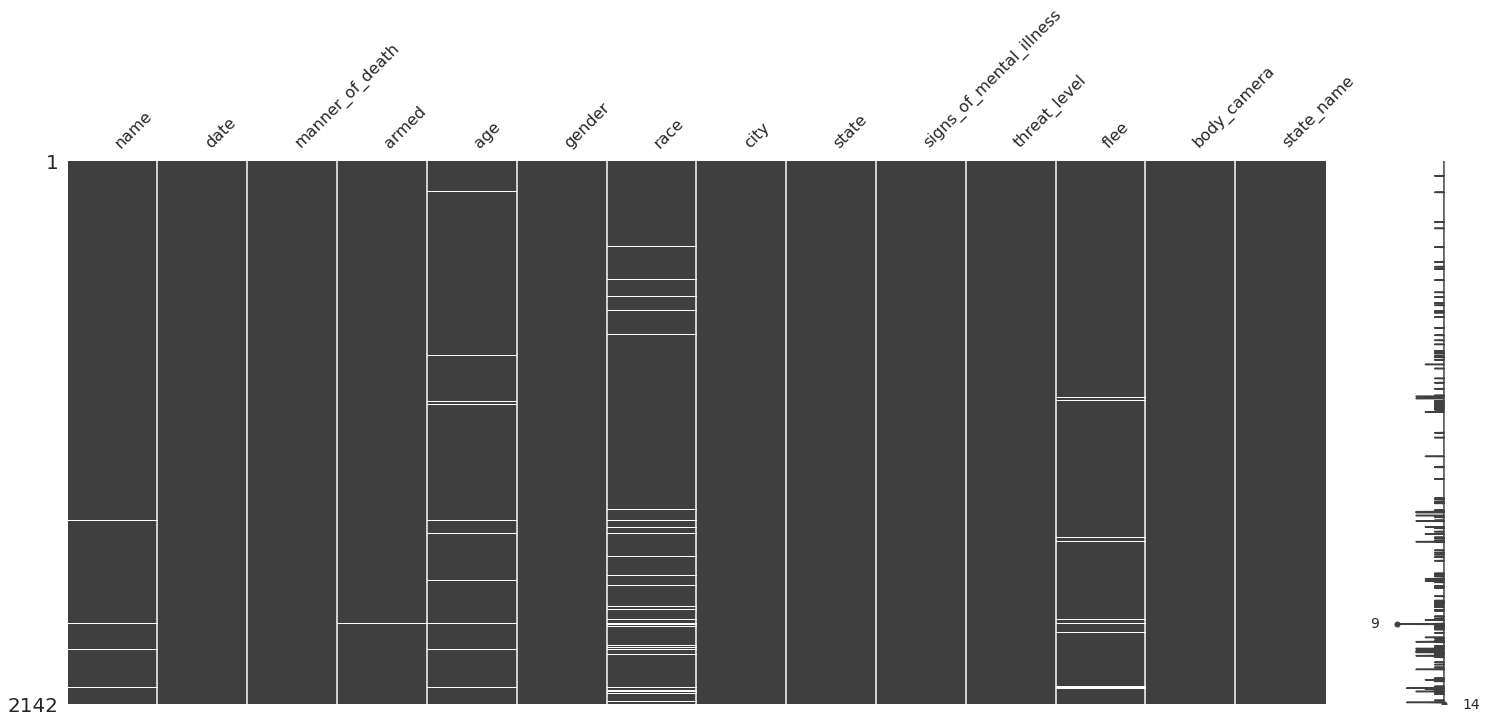

In [ ]:
msno.matrix(shootings_data)
plt.show()

Except for the `race` column, most of the missing values are distributed quite sparsely across the dataset. The missing values of 'race' need to be examined more closely to see how they might affect the analysis. Most importantly, the locations of missing `race` values should be assessed.

In [ ]:
null_mask = shootings_data["race"].isnull()
null_race = shootings_data[null_mask]
null_race_locations = null_race["state_name"].value_counts()

In [ ]:
proportion = null_race_locations / shootings_data["state_name"].value_counts()
proportion.sort_values(ascending=False)

Arkansas                0.190476
Connecticut             0.142857
Wyoming                 0.125000
Maine                   0.125000
West Virginia           0.120000
Oklahoma                0.107692
Pennsylvania            0.090909
Nevada                  0.085714
Alaska                  0.083333
Georgia                 0.080645
Colorado                0.078125
California              0.070423
New Jersey              0.068966
Tennessee               0.062500
Oregon                  0.062500
Missouri                0.056604
Indiana                 0.054054
Arizona                 0.052632
New Mexico              0.045455
Alabama                 0.045455
Washington              0.042553
Louisiana               0.041667
Florida                 0.038760
Texas                   0.035533
Ohio                    0.031746
Maryland                0.030303
Kentucky                0.025641
New York                0.024390
North Carolina          0.015385
Delaware                     NaN
District o

If the shootings in some states are racially biased, the missing information could be problematic when making firm conclusions as in some states more than 10% data is missing (and in Arcansas almost a fith of data about race is missing). In this EDA, it is decided to leave out all the missing data except for the data where only name is missing because it is not relevant for the analysis.

In [ ]:
shootings_data = shootings_data.dropna(subset=['race', 'armed', 'age', 'flee'])
shootings_data.shape

(1986, 14)

Dealing with duplicates:

In [ ]:
shootings_data.duplicated().sum()

1

In [ ]:
duplicate_rows = shootings_data[shootings_data.duplicated(keep=False)]
duplicate_rows

,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,state_name
id,,,,,,,,,,,,,,
2304,Jamake Cason Thomas,2017-02-03,shot,gun,22.0,M,B,Rowland,NC,False,attack,Car,False,North Carolina
2294,Jamake Cason Thomas,2017-02-03,shot,gun,22.0,M,B,Rowland,NC,False,attack,Car,False,North Carolina


In [ ]:
shootings_data = shootings_data.drop_duplicates()

Are there any people in the data that have the same name?

In [ ]:
shootings_data[shootings_data.duplicated("name", keep=False) == True]

,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,state_name
id,,,,,,,,,,,,,,
229,Brandon Jones,2015-03-19,shot,unarmed,18.0,M,B,Cleveland,OH,False,attack,Not fleeing,False,Ohio
291,Eric Harris,2015-04-02,shot,unarmed,44.0,M,B,Tulsa,OK,False,other,Not fleeing,False,Oklahoma
1129,Daquan Antonio Westbrook,2015-12-24,shot,gun,18.0,M,B,Charlotte,NC,False,attack,Not fleeing,False,North Carolina
1252,Eric Harris,2016-02-08,shot,vehicle,22.0,M,B,New Orleans,LA,False,other,Car,False,Louisiana
1526,Michael Johnson,2016-05-09,shot,gun,26.0,M,W,Chicago,IL,False,other,Foot,False,Illinois
1586,Michael Johnson,2016-06-01,shot,gun,21.0,M,B,Newnan,GA,False,attack,Foot,True,Georgia
1991,Brandon Jones,2016-10-25,shot,toy weapon,25.0,M,W,Elkton,MD,True,attack,Not fleeing,False,Maryland
2158,Daquan Antonio Westbrook,2016-12-24,shot,gun,18.0,M,B,Charlotte,NC,False,undetermined,Not fleeing,False,North Carolina


The name of Daquan Antonio Westbrook is duplicated and it seems that it is the same person only the date of the shooting does not match. He was shot in 2015, so one row needs to be removed.

In [ ]:
shootings_data = shootings_data.drop(index=2158)

## 2 Queries and Visualizations of the US Fatal Police Shootings Data of 2015 - 2017

### 2.1 General Tendencies in the US Police Shootings

#### 2.1.1 Police Shootings Timeline

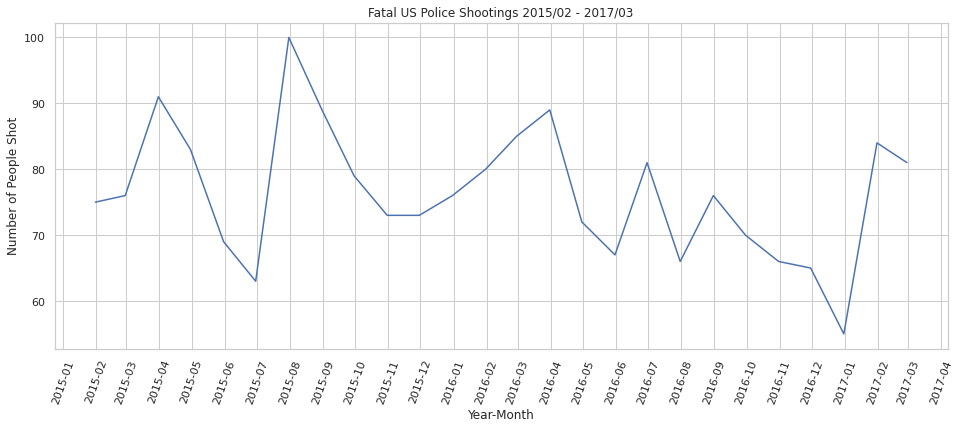

In [ ]:
shootings_timeline = shootings_data.groupby(pd.Grouper(key='date', axis=0, 
                      freq='M')).size()

sns.set_theme(style="whitegrid", palette="deep")

plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=shootings_timeline.index, y=shootings_timeline.values)
plt.title('Fatal US Police Shootings 2015/02 - 2017/03')
plt.xlabel('Year-Month')
plt.ylabel('Number of People Shot')
plt.xticks(rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.show()


The highest number of people shot by the police was in August 2018 and the lowest number of police shootings was in January 2017. In general, it seems that there is no seasonality in police killings.

What about the police shootings and their relation to days of the week?


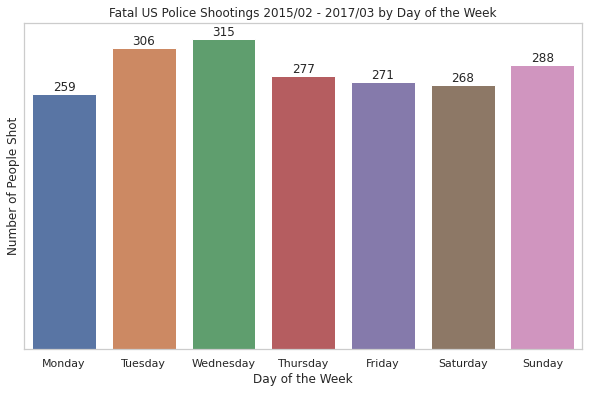

In [ ]:
shootings_by_weekday = shootings_data.groupby(
    shootings_data['date'].dt.day_name()).size()

order = ["Monday", "Tuesday", "Wednesday", 
         "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=shootings_by_weekday.index, 
                 y=shootings_by_weekday.values, 
                 order=order)
plt.title('Fatal US Police Shootings 2015/02 - 2017/03 by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of People Shot')
ax.bar_label(ax.containers[0])
plt.yticks([])
plt.show()

Most of the police shootings happened on Wednesdays and the least happened on Mondays. It looks like there are no obvious relation between the police shootings and weekends or weekdays because the variation in the number of people shot during different days of the week is not that high.

#### 2.1.2 Police Shootings and Gender

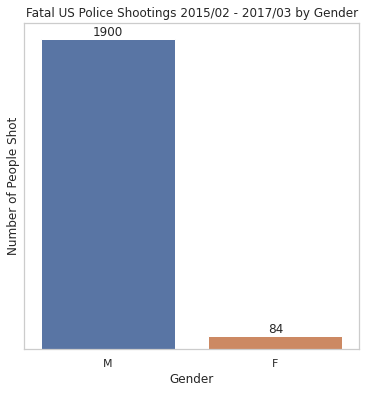

In [ ]:
gender = shootings_data['gender'].value_counts()

plt.figure(figsize=(6, 6))
ax = sns.barplot(x=gender.index, y=gender.values)
plt.title('Fatal US Police Shootings 2015/02 - 2017/03 by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of People Shot')
ax.bar_label(ax.containers[0])
plt.yticks([])
plt.show()

The overwhelming majority of people shot by the police are male.

#### 2.1.3 Police Shootings and Age

In the police shootings dataset, `age` is the only numeric feature with continuous values. Other features are categorical.

In [ ]:
shootings_data.describe()

,age
count,1984.000000
mean,36.127016
std,12.645522
min,6.000000
25%,26.000000
50%,34.000000
75%,45.000000
max,83.000000


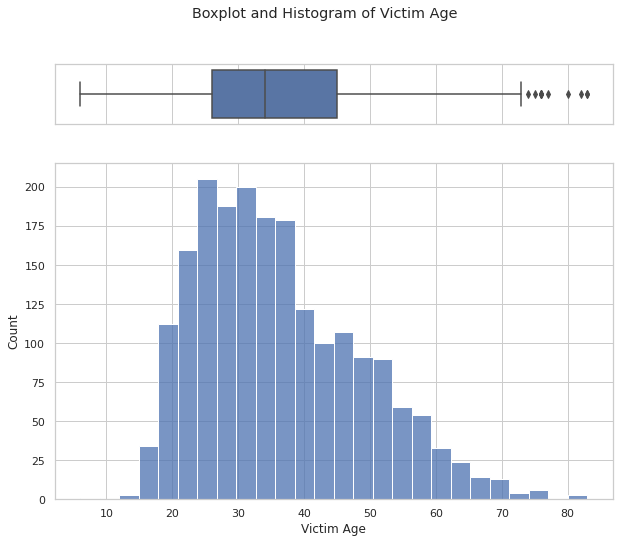

In [ ]:
sns.set_style("whitegrid")
f, ax = plt.subplots(2, 
                     figsize=(10, 8), 
                     gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=shootings_data.age, ax=ax[0])
ax[0].set_xlabel(None)
ax[0].set_xticklabels([])
sns.histplot(x=shootings_data.age, ax=ax[1])
ax[1].set_xlabel("Victim Age")
plt.suptitle("Boxplot and Histogram of Victim Age")
plt.show()

The data in the `age` column has a seemingly normal distribution and only a few outliers. It looks like there is a big variety of victim age, but most of the police shooting victims were between 26 and 45 years old.

#### 2.1.4 Police Shootings and their Location

What are the most dangerous US states based on the overall number of the police shootings?

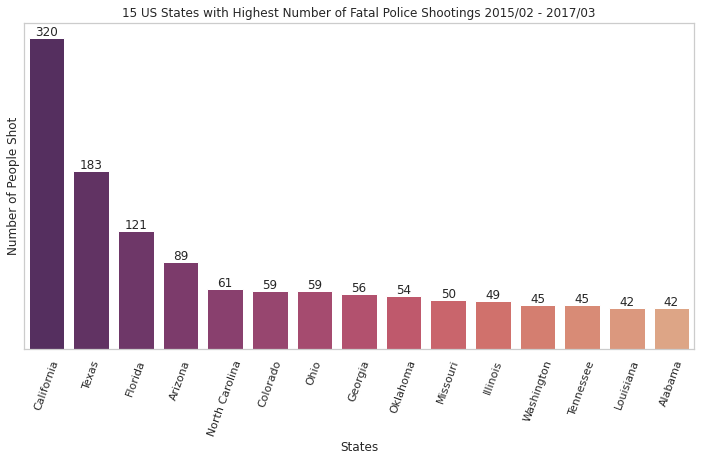

In [ ]:
order = shootings_data["state_name"].value_counts()[0:15].index

plt.figure(figsize=(12, 6))
ax = sns.countplot(x="state_name", 
                   order=order,
                   data=shootings_data,
                   palette="flare_r")
plt.title('15 US States with Highest Number of' +
          ' Fatal Police Shootings 2015/02 - 2017/03')
plt.xlabel('States')
plt.ylabel('Number of People Shot')
plt.yticks([])
plt.xticks(rotation=70)
ax.bar_label(ax.containers[0])
plt.show()

What are the most dangerous US cities based on the overall number of the police shootings? Are the cities with most shootings are in the same states?

In [ ]:
shootings_data.groupby(['city', "state_name"]).size().nlargest(15)

city           state_name
Los Angeles    California    30
Phoenix        Arizona       22
Houston        Texas         21
Chicago        Illinois      20
Las Vegas      Nevada        15
Austin         Texas         14
Miami          Florida       14
San Antonio    Texas         14
Columbus       Ohio          13
Indianapolis   Indiana       13
Tucson         Arizona       12
Albuquerque    New Mexico    11
Bakersfield    California    11
Oklahoma City  Oklahoma      11
St. Louis      Missouri      10
dtype: int64

There is a rough overlap with the states and cities with the most overall police shootings. Yet, some of the most dangerous cities are not from the most dangerous states, for example Albuquerque in New Mexico.

Determining the most dagerous states based only on the overall number of police shootings could be considered quite trivial. For this reason, the next step in this analysis is to compare the police shootings in different US states in proportion to their population. The population data will be gathered from the [2016 US Census](https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?dataView=1&currentTimeframe=3&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D).

In [ ]:
census_2016 = pd.read_csv("/content/us_population_raw_data_2016.csv")
census_2016 = census_2016.drop(index=52)
census_2016['State_code'] = census_2016['Location'].map(us_state_abbrev)

Which of the US states have the highest number of fatal police shootings per 1 000 000 of population?

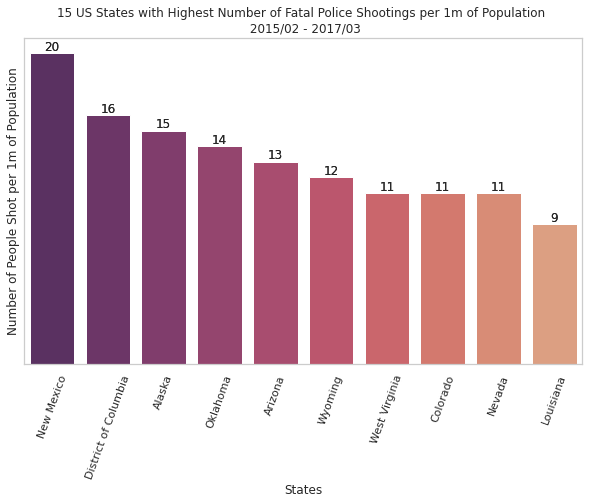

In [ ]:
a = shootings_data["state_name"].value_counts().to_frame()
b = census_2016.set_index("Location")["Total"]
state_kills = pd.merge(a, b, left_index=True, right_index=True)
state_kills.set_axis(["killed", "population"], axis=1, inplace=True)
weighted_state_kills = state_kills["killed"] / state_kills["population"] \
* 1000000

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=weighted_state_kills.index, 
                 y=weighted_state_kills.round().values, 
                 order=weighted_state_kills.sort_values(
                     ascending=False).index[:10],
                 data=shootings_data,
                 palette="flare_r")
ax.bar_label(ax.containers[0])
plt.title('15 US States with Highest Number of Fatal Police Shootings per ' + 
          '1m of Population \n 2015/02 - 2017/03')
plt.xlabel('States')
plt.ylabel('Number of People Shot per 1m of Population')
plt.yticks([])
plt.xticks(rotation=70)
ax.bar_label(ax.containers[0])
plt.show()

The weighted police shootings data is worthy displaying on the US map to get a nicer overview of the most and least dangerous locations.

In [ ]:
map_data = weighted_state_kills.copy().to_frame()
map_data["state_code"] = map_data.index.map(us_state_abbrev)
map_data.set_axis(["killed", "state_code"], axis=1, inplace=True)

In [ ]:
data = dict(type = "choropleth",
            colorscale = "Brwnyl",
            z = map_data["killed"].round(),
            locations = map_data["state_code"],
            locationmode = "USA-states",
            text=weighted_state_kills.index,
            marker_line_color='white',
            hovertemplate =  
            "<b>%{text} </b><br>" +
            "People shot per<br>1m of population:  %{z}<br>",
            colorbar = {"title" : "No. of People Shot<br>per 1m of Population"})

layout = dict(title = "Fatal Police Shootings in the US (2015/02 - 2017/03)",
              geo = dict(scope = "usa"))

choromap = go.Figure(data = [data], layout=layout)

choromap.add_scattergeo(
    locations=map_data["state_code"],
    locationmode='USA-states',
    text=map_data["state_code"],
    mode='text',
    hoverinfo='skip')
choromap.show()

### 2.2 Can all of the US Police Shootings be Justified?

#### 2.2.1 Police Usage of Tasers before Shooting

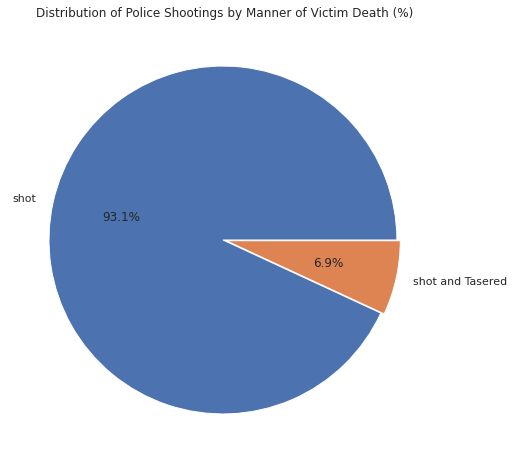

In [ ]:
shootings_data['manner_of_death'].value_counts(ascending=False).plot(
            kind="pie",
            autopct='%1.1f%%',
            explode=[0.01] * 2,
            figsize=(8, 8))
plt.ylabel("")
plt.title('Distribution of Police Shootings by Manner of Victim Death (%)')
plt.show()

Only a minor part of police shooting victims in the US were tasered before they got shot. This could lead to an assumption that policemen in general hesitate to use tools to prevent unnecessary killings. Yet, it is debatable if the tasering can really help in these life thretening situations as it is reported that it often leads to a more agressive behaviour of the victim. [Read more](https://www.apmreports.org/episode/2019/05/09/when-tasers-fail).

#### 2.2.2 Police Shootings and Signs of Mental Illness in Victim Behaviour

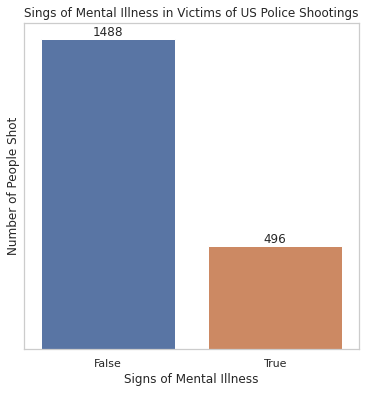

In [ ]:
mental_illness = shootings_data["signs_of_mental_illness"].value_counts()

plt.figure(figsize=(6, 6))
ax = sns.barplot(x=mental_illness.index, y=mental_illness.values)
plt.title('Sings of Mental Illness in Victims of US Police Shootings')
plt.xlabel('Signs of Mental Illness')
plt.ylabel('Number of People Shot')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.show()

Did police shooting victims with mental illness had a similar threat level as those who did not display any signs of mental illness?

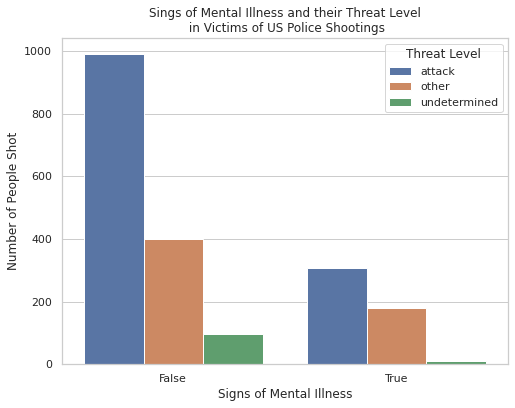

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=shootings_data['signs_of_mental_illness'], 
                   hue=shootings_data['threat_level'])
plt.title('Sings of Mental Illness and their Threat Level' + 
          '\n in Victims of US Police Shootings')
plt.xlabel('Signs of Mental Illness')
plt.ylabel('Number of People Shot')
plt.legend(title='Threat Level')
plt.show()

Both of the victims with or without signs of mental illness were mostly shot when they were in a position of attack making it more difficult for the police officers to chose a different approach to the situation. Nonetheless, considering the fact that a quarter of police shooting victims displayed signs of mental illness, it would be beneficial to dedicate more time on police officer training so they would not mistake victim condition with aggressive behaviour.

#### 2.2.3 Police Shootings and Victim Ways of Being Armed

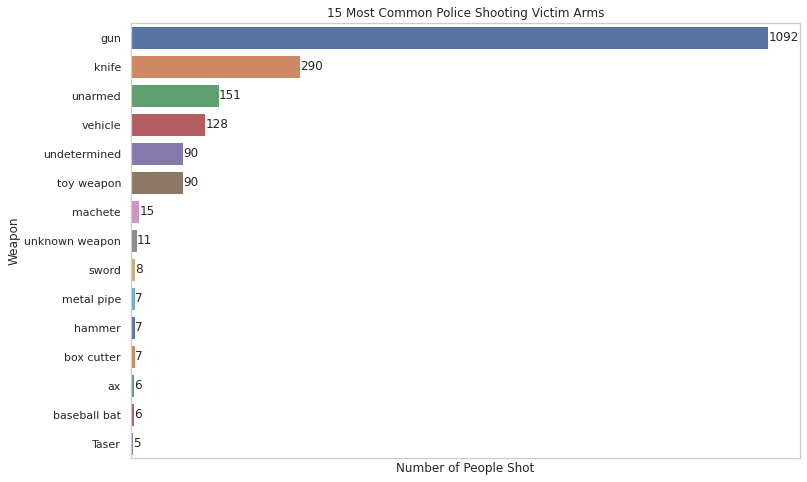

In [ ]:
armed = shootings_data["armed"].value_counts()[:15]

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=armed.values, 
                 y=armed.index, 
                 data=shootings_data,
                 palette="deep")
plt.xlabel('Number of People Shot')
plt.ylabel('Weapon')
plt.xticks([])
plt.title("15 Most Common Police Shooting Victim Arms")
ax.bar_label(ax.containers[0])
plt.show()

The vast majority of people shot by the US police were armed with lethal weapons making the police approach of shooting them more justified. Although, there might be some cases where this approach could potentially be avoided. Some of these cases should be investigated.

A youthful looking person could be suspected to cary a toy gun and thus the shooting could be avoided. So, what is the age distribution of people armed with a toy gun? Do only younger people tend to be armed with a toy gun?

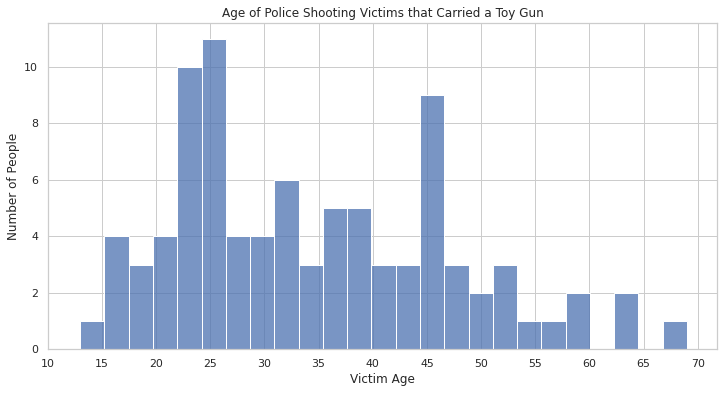

In [ ]:
toy_weapon = shootings_data[shootings_data["armed"] == "toy weapon" ]

plt.figure(figsize=(12, 6))
ax = sns.histplot(x=toy_weapon.age,
                  bins=25)
plt.xlabel('Victim Age')
plt.ylabel('Number of People')
plt.title("Age of Police Shooting Victims that Carried a Toy Gun")
ax.set_xticks(np.arange(10, 75, 5))
plt.show()

It seems that not that many victims that carried a toy gun were actually underaged.

In [ ]:
underage = toy_weapon[toy_weapon['age'] < 18]
underage

,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,state_name
id,,,,,,,,,,,,,,
553,Shelly Haendiges,2015-06-12,shot,toy weapon,17.0,F,W,Kokomo,IN,True,attack,Not fleeing,False,Indiana
1394,Robert Dentmond,2016-03-20,shot,toy weapon,16.0,M,B,Gainesville,FL,True,other,Not fleeing,False,Florida
1883,Tyre King,2016-09-14,shot,toy weapon,13.0,M,B,Columbus,OH,False,other,Foot,False,Ohio
1922,Daniel Perez,2016-10-02,shot,toy weapon,16.0,M,H,Los Angeles,CA,True,attack,Not fleeing,True,California
2316,Quanice Derrick Hayes,2017-02-09,shot,toy weapon,17.0,M,B,Portland,OR,False,undetermined,Foot,False,Oregon


Some killings of the underage victims might seem unreasonable because they were not attacking and one of them was not even fleeing.

How many people of all that were shot by the US police were unarmed, not fleeing, and not atacking?

In [ ]:
unarmed = shootings_data[shootings_data["armed"] == "unarmed"]
no_threat = unarmed[(
    unarmed["threat_level"] != 'attack') & (unarmed["flee"] == "Not fleeing")]
len(no_threat)

49

49 victims cosntitute only 3 percent of the total, but it is still a signifficant number considering the fact that these people were shot even though they were not seemingly threatful.

### 2.3 Are the US Police Shootings Racialy Biased?

#### 2.3.1 Number of Police Shootings by Race

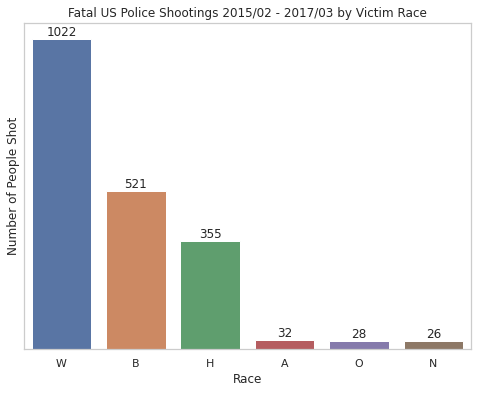

In [ ]:
shootings_by_race = shootings_data.race.value_counts()

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=shootings_by_race.index,
            y=shootings_by_race.values)
plt.xlabel('Race')
plt.ylabel('Number of People Shot')
plt.title("Fatal US Police Shootings 2015/02 - 2017/03 by Victim Race")
ax.bar_label(ax.containers[0])
plt.yticks([])
plt.show()

The races of Asian (A), White (W), Hispanic (H), Black (B), Native American (N) and Other (O) are represented in the police shootings dataset. In the bar chart above, we can see that the vast majority of people killed by the US police are White. Nonetheless, the data should be assessed considering the total population of each race.

In [ ]:
census_2016["Native Americans"] = census_2016["American Indian/Alaska Native"] \
+ census_2016["Native Hawaiian/Other Pacific Islander"]
census_2016 = census_2016.drop(
    columns=["Multiple Races", 
             "American Indian/Alaska Native", 
             "Native Hawaiian/Other Pacific Islander"])
census_2016.set_axis([
                      'Location', 'W', 'B', 'H', 'A', 
                      "Total", "State_code", "N"], axis=1, inplace=True)
census_2016.head()

,Location,W,B,H,A,Total,State_code,N
0,United States,192537500,38081700.0,56144400,17004500.0,314466400,NaN,2556100.0
1,Alabama,3121800,1252500.0,194500,57600.0,4730100,AL,NaN
2,Alaska,439200,20700.0,47800,42600.0,714900,AK,116000.0
3,Arizona,3754900,270000.0,2087500,213600.0,6760900,AZ,278300.0
4,Arkansas,2114900,441600.0,210000,39500.0,2895400,AR,25000.0


What is the number of US police shootings of each race per 1 000 000 of their population?

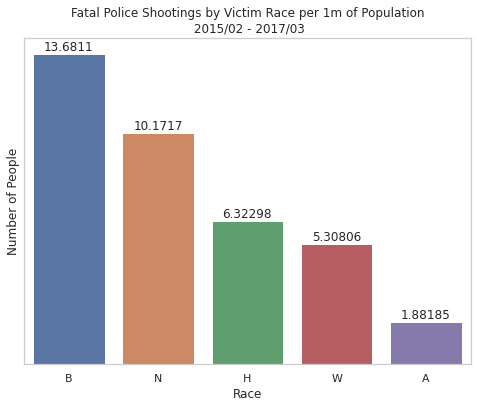

In [ ]:
US_pop = census_2016.loc[0]
race_kills = pd.merge(
    shootings_by_race, US_pop, left_index=True, right_index=True)
race_kills.set_axis(["killed", "population"], axis=1, inplace=True)
weighted_race_kills = race_kills["killed"] / race_kills["population"] * 1000000
weighted_race_kills = weighted_race_kills.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=weighted_race_kills.index,
            y=weighted_race_kills.values)
plt.xlabel('Race')
plt.ylabel('Number of People')
plt.title("Fatal Police Shootings by Victim Race per 1m of Population" +
          "\n 2015/02 - 2017/03")
ax.bar_label(ax.containers[0])
plt.yticks([])
plt.show()

The weigted assessment of the US police shootings by victim race had shown that the most frequently killed people are actually Black, Native American and Hispanic while White people are among the people that are least likely to be killed by the police.

#### 2.3.2 Relation of Race and US Police Shootings of the Unarmed

The most obvious way of testing if the police shootings in the US are racially biased is the assessment of killings of people that displayed the least threat.

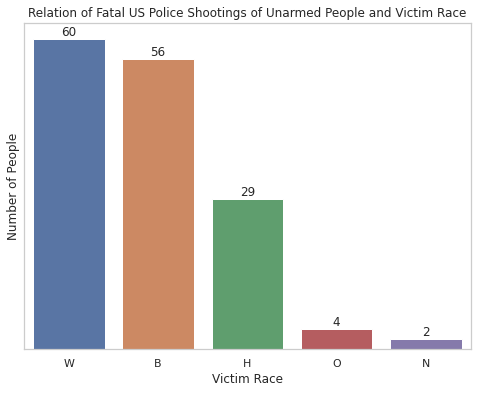

In [ ]:
unarmed = shootings_data[shootings_data["armed"] == "unarmed"]
unarmed = unarmed['race'].value_counts()

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=unarmed.index,
            y=unarmed.values)
plt.xlabel('Victim Race')
plt.ylabel('Number of People')
plt.title("Relation of Fatal US Police Shootings" + 
          " of Unarmed People and Victim Race")
ax.bar_label(ax.containers[0])
plt.yticks([])
plt.show()

The racial bias of police shootings can already be suspected from the chart above as it shows that unarmed Black people are killed almost as often as White people although their population is significantly smaller. The racial bias can be seen even more vividly in the bellow bar chart that represents the number of unarmed people shot by the police weighted by population of their race.

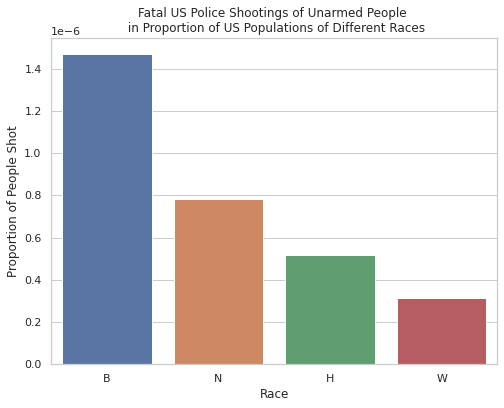

In [ ]:
unarmed_race = pd.merge(unarmed, US_pop, left_index=True, right_index=True)
unarmed_race.set_axis(["killed", "population"], axis=1, inplace=True)
weighted_unarmed_race = unarmed_race['killed'] / unarmed_race["population"]
weighted_unarmed_race = weighted_unarmed_race.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=weighted_unarmed_race.index,
            y=weighted_unarmed_race.values)
plt.xlabel('Race')
plt.ylabel('Proportion of People Shot')
plt.title("Fatal US Police Shootings of Unarmed People" + 
          " \n in Proportion of US Populations of Different Races")
plt.show()

#### 2.3.3 Police Shootings of Black People in Different US States

The above findings show that in the US people of Black race are more likely to be shot by the police than people of other races. It is thus worthy to map which of the states are know for more frequent police shootings of the Black people.

In [ ]:
a = shootings_data[shootings_data['race'] == 'B']
c = a["state_name"].value_counts().to_frame()
g = census_2016.set_index("Location")["B"]
black_state_kills = pd.merge(c, g, left_index=True, right_index=True)
black_state_kills.set_axis(["killed", "population"], axis=1, inplace=True)
weighted_black_state_kills = black_state_kills["killed"] / \
state_kills["population"] * 1000000

shoot_data = weighted_black_state_kills.copy().to_frame()
shoot_data["state_code"] = shoot_data.index.map(us_state_abbrev)
shoot_data.set_axis(["killed", "state_code"], axis=1, inplace=True)

data = dict(type = "choropleth",
            colorscale = "Brwnyl",
            z = shoot_data["killed"].round(),
            locations = shoot_data["state_code"],
            locationmode = "USA-states",
            text=weighted_black_state_kills.index,
            marker_line_color='white',
            hovertemplate =  
            "<b>%{text} </b><br>" +
            "Black people shot per<br>1m of population:  %{z}<br>",
            colorbar = {"title" : "No. of Black People Shot"
            + "<br>per 1m of Population"})

layout = dict(title = "Fatal Police Shootings of Black People" + 
              " in the US 2015/02 - 2017/03",
              geo = dict(scope = "usa"))

choromap = go.Figure(data = [data], layout=layout)

choromap.add_scattergeo(
    locations=shoot_data["state_code"],
    locationmode='USA-states',
    text=shoot_data["state_code"],
    mode='text',
    hoverinfo='skip')
choromap.show()

Lousiana, Maryland, Oklahoma, and Missouri are the states with the most "unfriendly" police officers for the Black people. New Mexico is interestingly the state with most frequent overall police shootings but no shootings of the Black people at all. What is the racial police shootings distribution in New Mexico?

In [ ]:
nm_kills = shootings_data[shootings_data["state"] == "NM"]
nm_kills = nm_kills["race"].value_counts()
nm_kills

H    24
W    15
N     1
Name: race, dtype: int64